## Beyond Linearity 1

We need to add some additional packages to make this work.

So start with *pip3 install ISLP*.  ISLP is a package from a book entitled 'Introduction to Statistical Learning with Python'.

We'll also need the *pygam* package.

Then *pip3 install pygam*

In [98]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt

from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [99]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

We are going to start with some data on wages.  We'll look at the data on wages with age as a predictor.

In [100]:
Wage = load_data('Wage')
print(Wage.info())
y = Wage['wage']
age = Wage['age']
Wage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB
None


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


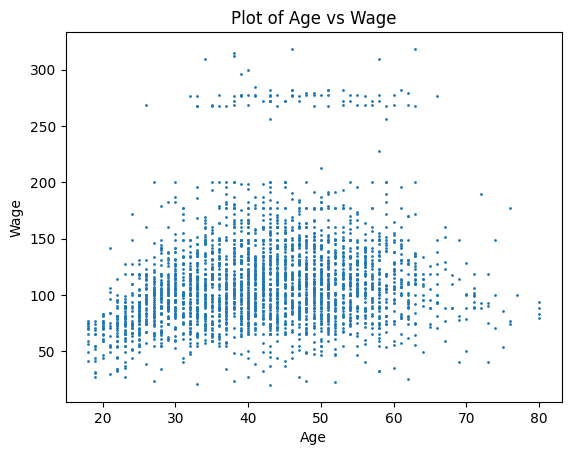

In [101]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')
plt.show()

So that scatterplot suggests that we have a non-linear relationship here.

So let's build some non-linear models.

### Polynomial Regression

Polynomial regression means that we have a regression with predictors $x$, $x^2$, $x^3$, ..., to $x^d$ where
$d$ is the degree of the polynomial.  So a cubic is of degree 3 and a linear function would be of degree 1.

We will do this in a special way that make the predictors not be correlated.  Math.

In [102]:
# This builds the fourth degree polynomial predictors for age
# so that we have in poly_age: age, age^2, age^3, age^4
poly_age = MS([poly('age', degree=4)]).fit(Wage)
# Use the polynomials of age to fit a regression model an 
# ordinary least squares (OLS) one 
M = sm.OLS(y, poly_age.transform(Wage)).fit()
# get the summary for this model
summarize(M)


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In the output above, we have the y-intercept (111.7), then the coefficient for age (447.1), the coefficient for age^2 (-478.3),
    the coefficient for age^3 (125.5) and the coefficient for age^4 (-77.9).

For making predictions, we create a set of values in *age_grid* and then we'll match the structure of the polynomials
by transforming them to make them not correlated as we did above.

In [103]:
#make a set of 100 values from the smallest age to the largest age
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
print(age_grid)

# put those values into a dataframe called age_df
age_df = pd.DataFrame({'age': age_grid})
# make the values at which we are going to predict and transform them 
Xnew = poly_age.transform(age_df)
# generated predicted values at the values in age_grid
preds = M.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds']=preds.predicted_mean


[18.         18.62626263 19.25252525 19.87878788 20.50505051 21.13131313
 21.75757576 22.38383838 23.01010101 23.63636364 24.26262626 24.88888889
 25.51515152 26.14141414 26.76767677 27.39393939 28.02020202 28.64646465
 29.27272727 29.8989899  30.52525253 31.15151515 31.77777778 32.4040404
 33.03030303 33.65656566 34.28282828 34.90909091 35.53535354 36.16161616
 36.78787879 37.41414141 38.04040404 38.66666667 39.29292929 39.91919192
 40.54545455 41.17171717 41.7979798  42.42424242 43.05050505 43.67676768
 44.3030303  44.92929293 45.55555556 46.18181818 46.80808081 47.43434343
 48.06060606 48.68686869 49.31313131 49.93939394 50.56565657 51.19191919
 51.81818182 52.44444444 53.07070707 53.6969697  54.32323232 54.94949495
 55.57575758 56.2020202  56.82828283 57.45454545 58.08080808 58.70707071
 59.33333333 59.95959596 60.58585859 61.21212121 61.83838384 62.46464646
 63.09090909 63.71717172 64.34343434 64.96969697 65.5959596  66.22222222
 66.84848485 67.47474747 68.1010101  68.72727273 69.

Below we make a plot and add the prediction equation in red to the plot.

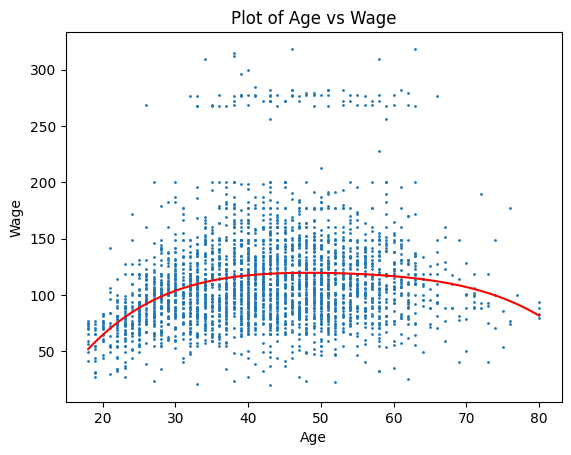

In [104]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add regression line to plot
plt.plot(age_df['age'],age_df['preds'] , color='red')

plt.show()

The above plot is the fourth order polynomial model for prediction of an individuals wage by age.

Note that the model is not quadratic as it has an extended area of peak which is not 
the form that a quadratic would take.

### Splines

Polynomials give us some flexibility in the relationship between our response/target and our 
features/predictors.  A *spline* is another way to build some flexibility into that relationship.

The idea of a spliced lines, or splines, is to fit a functional curve, by default cubic, to data in a window, then
fit another  curve to the next window, etc through all the windows, and have the lines be spliced together.
Where the windows come together are called knots because they 'tie together' one curve to the next.

We do this by creating bases, see Linear Algebra, as predictors which are effectively perpendicular to each other.

The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

In [105]:
# BSplines are basis splines (bs)
# basically these are orthogonal, read perpendicular, predictors that ensure there 
# is not much multicollinearity between them
# the knots are the locations on the x axis
bs_1 = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
# transform the splines to fit the age and the function below
bs_age = bs_1.transform(age)
# get the number of rows and columns for bs_age
bs_age.shape

(3000, 7)

The next set of code makes the necessary predictors to have splines between knots 
at ages 25, 40 and 60.  

In [106]:
bs_age = MS([bs('age', degree=3,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs = bs_age.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M2 = sm.OLS(y, Xbs).fit()
# get the coefficient summary for M2
summarize(M2)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, degree=3, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default,
`bs()` assumes `intercept=False`, since we typically have an overall intercept in the model.
So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

We could also use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 columns or degrees of freedom.  When we specify
`df=6` rather than the actual knots, `bs()` will produce a
spline with 3 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [107]:
BSpline(df=6).fit(age).internal_knots_


array([33.75, 42.  , 51.  ])

Next we will make predictions so we can plot and compare how the splines do compared to the polynomial regression.

In [108]:
# create the data for making predictions based upon the bs_age transformation
Xnew = bs_age.transform(age_df)
# get the predicted values from M2 which is our regression model
preds2 = M2.get_prediction(Xnew)

# M2.get_prediction gives a bunch of output we just wanted the predicted values/means
age_df['preds2']=preds2.predicted_mean

Next make the plots and compare the polynomial in *red* to the splines in *blue*.

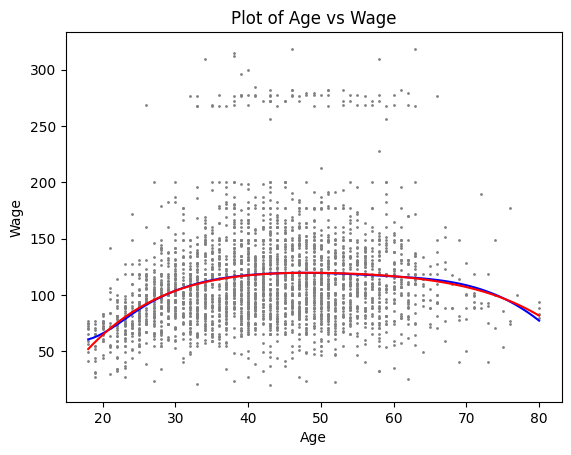

In [109]:
plt.scatter( Wage['age'],Wage['wage'],s=1, color="grey")

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='blue')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")

plt.show()

The predictions are similar but with some slight differences between the polynomial and the spline fit.
If we were to change the polynomial order or the type of spline we would get different predictions.



Below we will change the type of spline to be linear (degree=1) and refit the model. 

In [110]:
bs_age2 = MS([bs('age', degree=1,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs2 = bs_age2.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M3 = sm.OLS(y, Xbs2).fit()
# get the coefficient summary for M2
summarize(M3)

,coef,std err,t,P>|t|
intercept,54.3328,5.957,9.120,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[0]",37.6451,6.817,5.522,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[1]",65.8474,6.019,10.940,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[2]",63.8504,6.319,10.104,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[3]",33.7715,10.580,3.192,0.001


We've not interpreted these coefficients since they are a challenge to interpret since they depend upon the
basis functions that were defined.  What we can tell is that since all of the above coefficients have
small p-values, that they are worth keeping in the model.

Next we will get the predictions for the model *M3*.

In [111]:
Xnew = bs_age2.transform(age_df)

preds3 = M3.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds3']=preds3.predicted_mean

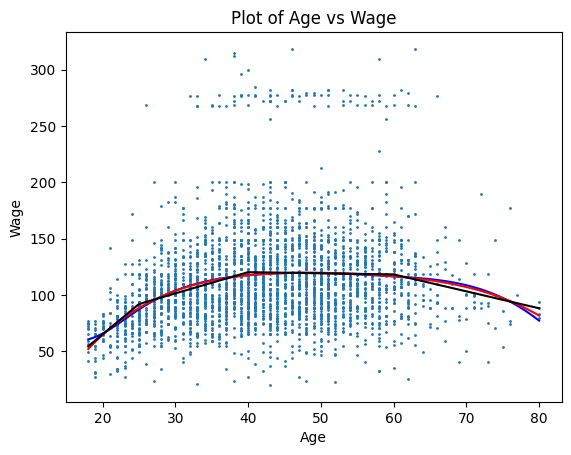

In [112]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='blue')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.show()

Let's change the y-axis so that we can more closely see that is going on.  

We'll do that below with the *plt.ylim* command.

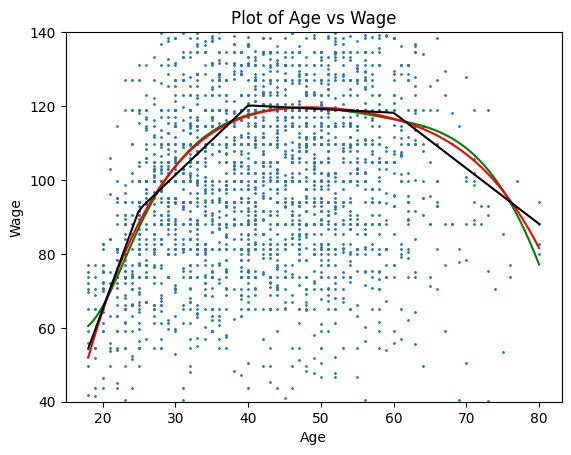

In [113]:
# note here that the addition of s=1 makes for 
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.ylim([40,140])
plt.show()

We specified knots at Age = 25,Age = 40, and Age =60.  From the black curve, which has a linear fit 
in each window we can clearly see the 'elbows' at those age values where the predicted curve 
changes slope while still being 'smooth' (or even continuous in a mathematical sense).



Tasks

1. Read in National Football League historical draft data located at http://myslu.stlawu.edu/~msch/data/NFLDraft.csv
    
2. G is the number of games played by a player in their career. Pick is the position at which they were selected in the National Football League (NFL) draft. Plot G vs Pick.

3. With G as the response and Pick as the predictor, fit a 4th degree polynomial, and a basis spline with 
    four knots at 30, 60, 90 and 120 that is degree 3, and another basis spline with the same knots that 
    is degree 1.

4. Plot the predicted functions for your models above.
    
5. How might you evaluation which method does the best job of prediction?


In [114]:
# read in the blue jay data
nfl = pd.read_csv("http://myslu.stlawu.edu/~msch/data/NFLDraft.csv")
# remove rows with missing data
#nfl.dropna(inplace=True)

nfl.head()


,Year,Rnd,Pick,Tm,,Pos,To,AP1,PB,GS,...,RushYds,RushTD,Rec,RecYds,RecTD,Tkl,Int,Sk,College/Univ,TradPower
0,1992,12,332,HOU,Joe Wood,K,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
1,1995,7,218,DEN,Steve Russ,LB,2000.0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
2,1997,6,178,SDG,Daniel Palmer,C,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Air Force,0
3,1999,7,248,BUF,Bryce Fisher,DE,2007.0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,176,NaN,26.5,Air Force,0
4,1993,8,224,TAM,Daron Alcorn,K,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akron,0


In [115]:
# the code below fills in missing values with zeros for each features/columns.
# we do this since if a player did not have a value we assume they 
# never played in a game, 'G  '
# or never started a game 'GS'
# or never had any career approximate value 'CarAV  '
nfl['G  ']=nfl['G  '].fillna(0)
nfl['GS']=nfl['GS'].fillna(0)
nfl['CarAV  ']=nfl['CarAV  '].fillna(0)


In [116]:
import matplotlib.pyplot as plt
from matplotlib import colors

Plot G vs. Pick

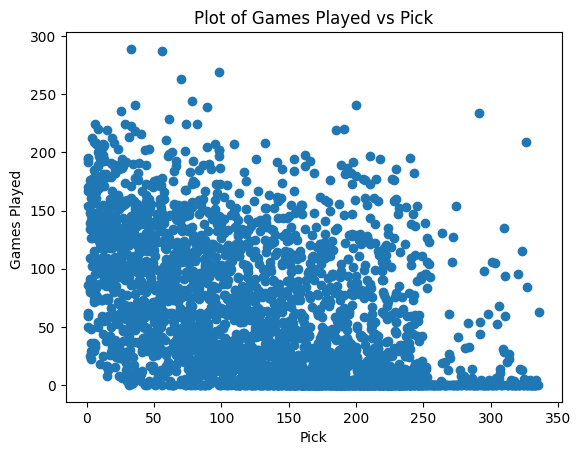

In [117]:

plt.scatter(nfl['Pick  '],  nfl['G  '])
plt.xlabel('Pick')
plt.ylabel('Games Played ')
plt.title('Plot of Games Played vs Pick')
# Add labels and title

plt.show()

The default size for the points is large, so let's make that smaller. This plot will make the trend a bit easier to see.

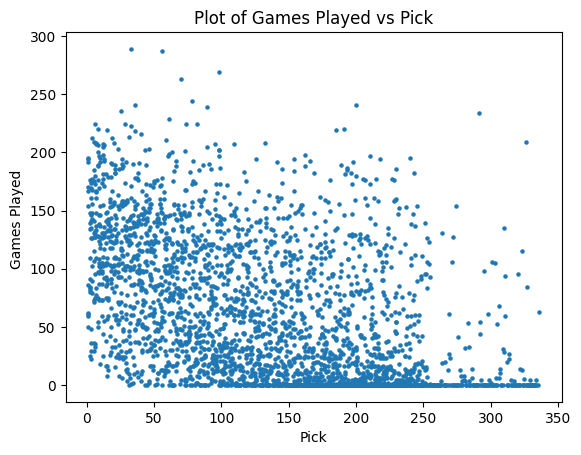

In [118]:

plt.scatter(nfl['Pick  '],  nfl['G  '],s=5)
plt.xlabel('Pick')
plt.ylabel('Games Played ')
plt.title('Plot of Games Played vs Pick')
# Add labels and title

plt.show()

We can also use an argument called alpha to make some of the points transparent.  Alpha takes
values between 0 and 1 and larger values of alpha are less transparent.

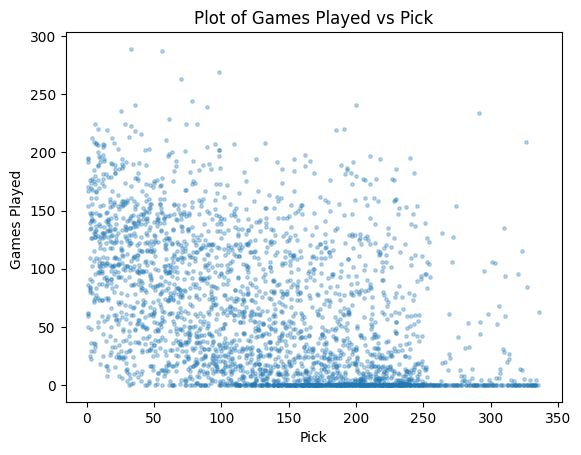

In [119]:

plt.scatter(nfl['Pick  '],  nfl['G  '], s=6,alpha=0.3)
plt.xlabel('Pick')
plt.ylabel('Games Played ')
plt.title('Plot of Games Played vs Pick')
# Add labels and title

plt.show()

Fit a fourth degree polynomial

In [120]:
print(nfl.info())
pick = nfl['Pick  ']
games = nfl['G  ']
# This builds the fourth degree polynomial predictors for age
# so that we have in poly_age: age, age^2, age^3, age^4
#
# pass to MS the column name in poly() and the dataframe name in fit


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          2853 non-null   int64  
 1   Rnd           2853 non-null   int64  
 2   Pick          2853 non-null   int64  
 3   Tm            2853 non-null   object 
 4                 2852 non-null   object 
 5   Pos           2853 non-null   object 
 6   To            2356 non-null   float64
 7   AP1           2853 non-null   int64  
 8   PB            2853 non-null   int64  
 9   GS            2853 non-null   float64
 10  St            2853 non-null   int64  
 11  CarAV         2853 non-null   float64
 12  G             2853 non-null   float64
 13  PassComp      211 non-null    object 
 14  PassAtt       211 non-null    object 
 15  PassYds       211 non-null    object 
 16  PassTDs       211 non-null    object 
 17  PassINT       211 non-null    object 
 18  RushAtt       550 non-null  

In [121]:
poly_pick = MS([poly('Pick  ', degree=4)]).fit(nfl)
# Use the polynomials of age to fit a regression model an 
# ordinary least squares (OLS) one 
M = sm.OLS(games, poly_pick.transform(nfl)).fit()
# get the summary for this model
summarize(M)

,coef,std err,t,P>|t|
intercept,61.5801,0.963,63.947,0.000
"poly(Pick , degree=4)[0]",-1495.0398,51.436,-29.066,0.000
"poly(Pick , degree=4)[1]",413.3947,51.436,8.037,0.000
"poly(Pick , degree=4)[2]",-105.9264,51.436,-2.059,0.040
"poly(Pick , degree=4)[3]",-29.7099,51.436,-0.578,0.564


In [122]:
#make a set of 100 values from the smallest age to the largest age
pick_grid = np.linspace(pick.min(),
                       pick.max(),
                       200)
print(pick_grid)

# put those values into a dataframe called pick_df

# for the dataframe that we make below we need to name the column
# the same name as the predictor in the model so that when 
# we use this dataframe for prediction the model can find the right
# variable
pick_df = pd.DataFrame({'Pick  ': pick_grid})


[  1.           2.68341709   4.36683417   6.05025126   7.73366834
   9.41708543  11.10050251  12.7839196   14.46733668  16.15075377
  17.83417085  19.51758794  21.20100503  22.88442211  24.5678392
  26.25125628  27.93467337  29.61809045  31.30150754  32.98492462
  34.66834171  36.35175879  38.03517588  39.71859296  41.40201005
  43.08542714  44.76884422  46.45226131  48.13567839  49.81909548
  51.50251256  53.18592965  54.86934673  56.55276382  58.2361809
  59.91959799  61.60301508  63.28643216  64.96984925  66.65326633
  68.33668342  70.0201005   71.70351759  73.38693467  75.07035176
  76.75376884  78.43718593  80.12060302  81.8040201   83.48743719
  85.17085427  86.85427136  88.53768844  90.22110553  91.90452261
  93.5879397   95.27135678  96.95477387  98.63819095 100.32160804
 102.00502513 103.68844221 105.3718593  107.05527638 108.73869347
 110.42211055 112.10552764 113.78894472 115.47236181 117.15577889
 118.83919598 120.52261307 122.20603015 123.88944724 125.57286432
 127.2562814

In [123]:

# make the values at which we are going to predict and transform them 
Xnew = poly_pick.transform(pick_df)
# generated predicted values at the values in age_grid
preds = M.get_prediction(Xnew)

#print(preds.summary_frame())
pick_df['preds_poly']=preds.predicted_mean

Fit a basis spline with four knots at 30, 60, 90 and 120 that is degree 3,

In [124]:
bs_pick = MS([bs('Pick  ', degree=3,internal_knots=[30,60,90,120])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs = bs_pick.fit_transform(nfl)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M_nfl = sm.OLS(games, Xbs).fit()
# get the coefficient summary for M2
summarize(M_nfl)

,coef,std err,t,P>|t|
intercept,123.1689,8.485,14.515,0.000
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[0]",2.6120,15.600,0.167,0.867
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[1]",-26.9773,10.112,-2.668,0.008
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[2]",-31.6260,11.313,-2.796,0.005
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[3]",-54.0689,9.167,-5.898,0.000
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[4]",-93.3691,11.946,-7.816,0.000
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[5]",-90.8090,13.364,-6.795,0.000
"bs(Pick , degree=3, internal_knots=[30, 60, 90, 120])[6]",-111.2745,12.126,-9.177,0.000


In [125]:
Xnew = bs_pick.transform(pick_df)
# generated predicted values at the values in age_grid
preds_spline3 = M_nfl.get_prediction(Xnew)

#print(preds.summary_frame())
pick_df['preds_spline3']=preds_spline3.predicted_mean

Fit another basis spline with the same knots that is degree 1.

In [126]:
bs_pick2 = MS([bs('Pick  ', degree=1,internal_knots=[30,60,90,120])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs2 = bs_pick2.fit_transform(nfl)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M_nfl2 = sm.OLS(games, Xbs2).fit()
# get the coefficient summary for M2
summarize(M_nfl2)

,coef,std err,t,P>|t|
intercept,128.0835,5.198,24.641,0.000
"bs(Pick , degree=1, internal_knots=[30, 60, 90, 120])[0]",-25.5419,7.498,-3.406,0.001
"bs(Pick , degree=1, internal_knots=[30, 60, 90, 120])[1]",-39.9760,6.094,-6.560,0.000
"bs(Pick , degree=1, internal_knots=[30, 60, 90, 120])[2]",-55.9244,6.419,-8.712,0.000
"bs(Pick , degree=1, internal_knots=[30, 60, 90, 120])[3]",-74.8085,5.623,-13.305,0.000
"bs(Pick , degree=1, internal_knots=[30, 60, 90, 120])[4]",-116.7445,6.465,-18.057,0.000


In [127]:
Xnew = bs_pick2.transform(pick_df)
# generated predicted values at the values in age_grid
preds_spline1 = M_nfl2.get_prediction(Xnew)

#print(preds.summary_frame())
pick_df['preds_spline1']=preds_spline1.predicted_mean

 Plot the predicted functions for your models above.

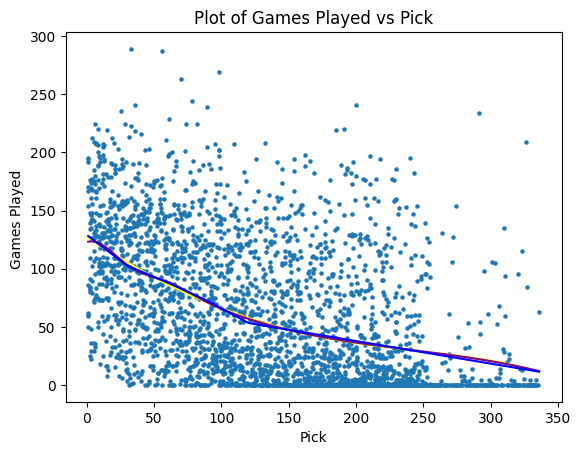

In [128]:

plt.scatter(nfl['Pick  '],  nfl['G  '],s=5)
plt.xlabel('Pick')
plt.ylabel('Games Played ')
plt.title('Plot of Games Played vs Pick')


# Add prediction line to plot
plt.plot(pick_df['Pick  '],pick_df['preds_poly'] , color='yellow')
# Add prediction line to plot
plt.plot(pick_df['Pick  '],pick_df['preds_spline3'],color="purple")
# Add prediction line for degree =2 spline
plt.plot(pick_df['Pick  '],pick_df['preds_spline1'],color="blue")

plt.show()

These curves look pretty similar; let's change the scales of the axes on the graph to get a better look

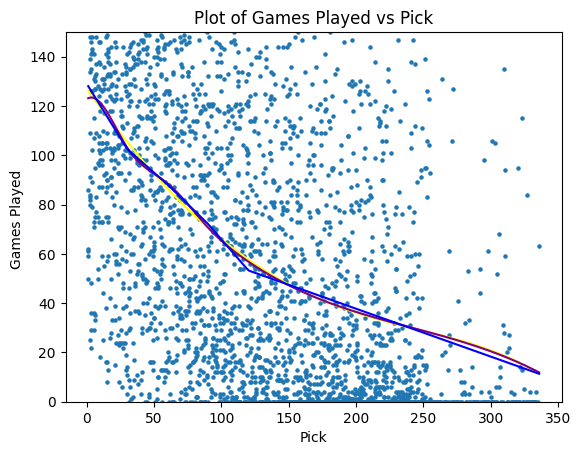

In [ ]:

plt.scatter(nfl['Pick  '],  nfl['G  '],s=5)
plt.xlabel('Pick')
plt.ylabel('Games Played ')
plt.title('Plot of Games Played vs Pick')


# Add prediction line to plot
plt.plot(pick_df['Pick  '],pick_df['preds_poly'] , color='yellow')
# Add prediction line to plot
plt.plot(pick_df['Pick  '],pick_df['preds_spline3'],color="purple")
# Add prediction line for degree =2 spline
plt.plot(pick_df['Pick  '],pick_df['preds_spline1'],color="blue")

# change the range of values that will be plotted on the y-axis
plt.ylim(0,150)
plt.show()


5. How might you evaluation which method does the best job of prediction?

The best method is likely to be looking at the RMSE's for each model and evaluating
their prediction.